## **Problem Statement**
Lending platforms face significant credit risk when issuing loans to borrowers. Without an effective risk assessment system, the company may experience financial losses due to high default rates. The dataset shows loans with "Charged Off" status that need to be anticipated from the outset to minimize portfolio risk.

## **Goal**
Develop a predictive model that can identify borrower default risk and classify them into risk tiers to support better lending decisions and optimize portfolio performance.

## **Objectives**

1. Understand the distribution and characteristics of borrowers, identify patterns and factors correlated with default risk, and analyze relationships between key variables such as income, DTI, credit history, and loan amount.

2. Build a predictive model to estimate default probability, perform feature engineering and selection, compare multiple algorithms, and optimize model performance through hyperparameter tuning.

3. Convert probability scores into actionable risk tiers with optimal thresholds based on risk appetite, and provide recommendations for each tier such as auto-approve, manual review, or reject.

4. Calculate potential loss rate reduction using the model, provide actionable insights for portfolio management, and create visualizations for ongoing risk monitoring.

## **0. Setup**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
# STANDARD LIBRARY
import time
import json
import warnings
warnings.filterwarnings('ignore')

# DATA MANIPULATION & NUMERICAL
import numpy as np
import pandas as pd

# VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns

# SKLEARN - BASE & UTILITIES
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# SKLEARN - PREPROCESSING
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder,
    StandardScaler, RobustScaler, MinMaxScaler,
    PowerTransformer, QuantileTransformer,
    FunctionTransformer
)

# SKLEARN - MODEL SELECTION & VALIDATION
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_val_score, GridSearchCV
)

# SKLEARN - FEATURE SELECTION
from sklearn.feature_selection import (
    SelectKBest, f_classif, SelectFromModel,
    VarianceThreshold
)

# SKLEARN - METRICS
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score,
    classification_report, confusion_matrix,
    log_loss, make_scorer, brier_score_loss,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# SKLEARN - CLASSIFICATION MODELS
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier
)

from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, VotingClassifier,
    HistGradientBoostingClassifier
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

# GRADIENT BOOSTING LIBRARIES
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# IMBALANCED LEARNING
from imblearn.ensemble import BalancedRandomForestClassifier

# HYPERPARAMETER OPTIMIZATION
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# FILE MANAGEMENT & UTILITIES
import joblib
from google.colab import drive

# MODEL INTERPRETATION
import shap
import datetime

In [ ]:
# MOUNT DRIVE
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

In [ ]:
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

mpl.rcParams['boxplot.boxprops.color'] = '#808080'
mpl.rcParams['boxplot.capprops.color'] = '#808080'
mpl.rcParams['boxplot.whiskerprops.color'] = '#808080'
mpl.rcParams['boxplot.medianprops.color'] = '#808080'
mpl.rcParams['boxplot.flierprops.color'] = '#808080'
mpl.rcParams['boxplot.meanprops.color'] = '#808080'

In [ ]:
# Tampilkan semua kolom dan baris
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Jangan potong lebar kolom
pd.set_option('display.max_colwidth', None)

# Tampilkan lebih banyak karakter di satu baris
pd.set_option('display.width', None)

## **1. Data Loading**

In [ ]:
# Load dataset and preview first rows
df = pd.read_csv(r"/content/drive/MyDrive/Rakamin/PBI/PBI November 2025/Dataset/loan_data_2007_2014.csv")
display(df.head())

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and f

In [ ]:
# Show dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
# Show dataset size, memory usage, and data type summary
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData Types Distribution:")
print(df.dtypes.value_counts())

Dataset Shape: 466,285 rows × 75 columns
Memory Usage: 779.95 MB

Data Types Distribution:
float64    46
object     22
int64       7
Name: count, dtype: int64


The dataset contains loan records from 2007 to 2014. Initial inspection reveals:

- **Dataset size**: The raw data includes numerous features capturing borrower information, loan characteristics, and payment history
- **Data types**: Mixed data types including numerical, categorical, and temporal features
- **Memory footprint**: Initial memory usage assessment helps identify potential optimization needs for large-scale processing

This stage establishes the foundation for subsequent preprocessing and ensures data accessibility for analysis.

## **2. Data Preprocessing**

### **2.0. Feature Engineering**

The target variable is created by categorizing loan status into binary outcomes (good vs bad loans). Several engineered features are added to capture risk-related patterns:

- **Temporal features**: Extract year, month, and quarter from issue dates to capture seasonality effects
- **Ratio features**: Calculate loan-to-income, payment-to-income, and credit utilization ratios to measure borrower capacity
- **Credit behavior metrics**: Derive account age, delinquency rates, and inquiry intensity to assess credit history quality
- **Categorical binning**: Group DTI and utilization into ranges for better interpretability

Target distribution shows class imbalance, with good loans significantly outnumbering bad loans, a typical characteristic in credit risk datasets.

In [ ]:
# Binary label for good vs bad loans
good_loan = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']

df['target'] = df['loan_status'].apply(lambda x: 0 if x in good_loan else (1 if x in bad_loan else None))
df = df[df['target'].notna()].copy()

print("Target Distribution:")
print(df['target'].value_counts())
print("\nPercentage:")
print(df['target'].value_counts(normalize=True) * 100)

Target Distribution:
target
0.0    186727
1.0     50968
Name: count, dtype: int64

Percentage:
target
0.0    78.557395
1.0    21.442605
Name: proportion, dtype: float64


In [ ]:
# Feature engineering and ratio calculations for cleaner modeling
def safe_divide(numerator, denominator, fill_value=0):
    result = numerator / denominator
    result = result.replace([np.inf, -np.inf], fill_value)
    return result

emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
df['emp_length_cat'] = pd.Categorical(df['emp_length'], categories=emp_order, ordered=True)

dti_ranges = pd.cut(df['dti'], bins=[0, 5, 10, 15, 20, 25, 50], labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25+'])
df['dti_range'] = dti_ranges

df['earliest_cr_line_dt'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce', infer_datetime_format=True)
df['credit_history_years'] = (pd.to_datetime('2016-01-01') - df['earliest_cr_line_dt']).dt.days / 365.25

util_ranges = pd.cut(df['revol_util'], bins=[0, 20, 40, 60, 80, 100, 200], labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100+'])
df['util_range'] = util_ranges

df['issue_d_dt'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df = df.dropna(subset=['issue_d_dt'])

df['issue_year'] = df['issue_d_dt'].dt.year
df['issue_month'] = df['issue_d_dt'].dt.month
df['issue_quarter'] = df['issue_d_dt'].dt.quarter

df['int_rate'] = (df['int_rate'].astype(str).str.replace('%', '', regex=False).astype(float))

df['loan_to_income'] = safe_divide(df['loan_amnt'], df['annual_inc'])
df['payment_to_income'] = safe_divide(df['installment'] * 12, df['annual_inc'])
df['credit_utilization'] = safe_divide(df['revol_bal'], df['total_rev_hi_lim'])
df['accounts_per_year'] = safe_divide(df['total_acc'], df['credit_history_years'])
df['avg_account_age'] = safe_divide(df['credit_history_years'], df['total_acc'])
df['delinq_rate'] = safe_divide(df['delinq_2yrs'], df['total_acc'])
df['inquiry_intensity'] = safe_divide(df['inq_last_6mths'], df['open_acc'])
df['funded_ratio'] = safe_divide(df['funded_amnt'], df['loan_amnt'])
df['annual_payment'] = df['installment'] * 12
df['revolving_income_ratio'] = safe_divide(df['revol_bal'], df['annual_inc'])
df['debt_burden'] = safe_divide(df['loan_amnt'] + df['revol_bal'], df['annual_inc'])

rare = ['OTHER', 'ANY', 'NONE']
df['home_ownership'] = df['home_ownership'].replace(rare, 'OTHER')

### **2.1. Drop Features**

Two categories of features are removed:

- **Leakage columns**: Features containing post-loan information (payments, recoveries, collection fees) that would not be available at prediction time
- **Irrelevant columns**: Identifiers, URLs, and redundant features that provide no predictive value

This reduces dimensionality while ensuring the model only uses information available at loan origination.

In [ ]:
# Drop Leakage Columns
leakage_cols = ['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt_inv', '_rec']
leakage_dropped = [c for c in leakage_cols if c in df.columns]

df = df.drop(columns=leakage_cols, errors='ignore')
print(f"Dropped {len(leakage_dropped)} leakage columns")

Dropped 14 leakage columns


In [ ]:
# Drop Irrelevant Columns
irrelevant_cols = ['Unnamed: 0', 'id', 'member_id', 'url', 'policy_code', 'emp_title', 'desc', 'title', 'issue_d_dt', 'zip_code', 'earliest_cr_line_dt', 'earliest_cr_line', 'issue_d', 'initial_list_status', 'loan_status', 'application_type']
irrelevant_dropped = [c for c in irrelevant_cols if c in df.columns]

df = df.drop(columns=irrelevant_cols, errors='ignore')
print(f"Dropped {len(irrelevant_dropped)} irrelevant columns")

Dropped 16 irrelevant columns


In [ ]:
# Summary
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")

Number of columns: 66
Number of rows: 237695


### **2.2. Missing Values Handling**

Missing value analysis reveals:

- Columns with 100% missing values are dropped immediately
- High missing rate columns (>50%) are removed due to insufficient information
- Remaining missing values are handled through imputation strategies in the preprocessing pipeline

This approach balances information retention with data quality.

In [ ]:
# Quick overview of missing values across all columns
missing_summary = (df.isnull().sum().reset_index().rename(columns={'index': 'column', 0: 'missing_count'}))
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
display(missing_summary[missing_summary['missing_pct'] > 0])

,column,missing_count,missing_pct
27,dti_joint,237695,100.000000
32,open_acc_6m,237695,100.000000
46,inq_last_12m,237695,100.000000
40,open_rv_24m,237695,100.000000
28,verification_status_joint,237695,100.000000
26,annual_inc_joint,237695,100.000000
33,open_il_6m,237695,100.000000
45,total_cu_tl,237695,100.000000
44,inq_fi,237695,100.000000
42,all_util,237695,100.000000


In [ ]:
# Drop columns with 100% missing values
threshold = 1.0
cols_100_missing = df.columns[df.isnull().sum() / len(df) == threshold]
df = df.drop(columns=cols_100_missing)

# Drop columns with high missing percentage (>50%)
threshold = 0.5
missing_pct = df.isnull().sum() / len(df)
high_missing_cols = missing_pct[missing_pct > threshold].index
df = df.drop(columns=high_missing_cols)

print(f"Columns remaining: {df.shape[1]}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

Columns remaining: 46
Remaining missing values: 607818


### **2.3. Outlier Handling Based on Domain Knowledge**

Domain-specific constraints are applied to detect impossible values:

- **Revol_util & credit_utilization**: Capped at 100% (utilization cannot exceed credit limit)
- **Credit_history_years**: Negative values corrected to zero
- **DTI**: Extreme values (>100%) capped at 60% based on industry standards

This ensures data validity without aggressive outlier removal that could eliminate legitimate edge cases.

In [ ]:
# Basic descriptive stats for key numeric features
numeric_cols = ['loan_amnt', 'dti', 'revol_util', 'loan_to_income', 'credit_utilization']
stats_list = []

for col in numeric_cols:
    if col in df.columns:
        stats_list.append({
            'variable': col,
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean(),
            'median': df[col].median(),
            'q1': df[col].quantile(0.25),
            'q99': df[col].quantile(0.99),
            'missing': df[col].isna().sum()
        })

stats_df = pd.DataFrame(stats_list)
display(stats_df)

,variable,min,max,mean,median,q1,q99,missing
0,loan_amnt,500.000000,35000.000000,13474.354320,12000.000000,7200.000000,35000.000000,0
1,dti,0.000000,39.990000,16.428473,16.130000,10.710000,33.900000,0
2,revol_util,0.000000,892.300000,54.970257,56.600000,37.200000,97.700000,231
3,loan_to_income,0.000789,1.337500,0.209450,0.196078,0.123527,0.466667,4
4,credit_utilization,0.000000,8.923333,0.563595,0.576439,0.395673,0.976737,66676


In [ ]:
# Simple checks and fixes for impossible outlier values
df_clean = df.copy()
outlier_report = []

if 'revol_util' in df_clean.columns:
    outliers = (df_clean['revol_util'] > 100).sum()
    if outliers > 0:
        print(f"REVOL_UTIL: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['revol_util'].max():.2f}%")
        df_clean.loc[df_clean['revol_util'] > 100, 'revol_util'] = 100
        print(f"   After:  Max = {df_clean['revol_util'].max():.2f}%")
        outlier_report.append(f"revol_util: {outliers} impossible values (>100%) capped at 100%")

if 'credit_utilization' in df_clean.columns:
    outliers = (df_clean['credit_utilization'] > 1.0).sum()
    if outliers > 0:
        print(f"\nCREDIT_UTILIZATION: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['credit_utilization'].max():.2f}")
        df_clean.loc[df_clean['credit_utilization'] > 1.0, 'credit_utilization'] = 1.0
        print(f"   After:  Max = {df_clean['credit_utilization'].max():.2f}")
        outlier_report.append(f"credit_utilization: {outliers} impossible values (>100%) capped at 1.0")

if 'credit_history_years' in df_clean.columns:
    outliers = (df_clean['credit_history_years'] < 0).sum()
    if outliers > 0:
        print(f"\nCREDIT_HISTORY_YEARS: {outliers} IMPOSSIBLE negative values detected")
        print(f"   Before: Min = {df_clean['credit_history_years'].min():.2f} years")
        df_clean.loc[df_clean['credit_history_years'] < 0, 'credit_history_years'] = 0
        print(f"   After:  Min = {df_clean['credit_history_years'].min():.2f} years")
        outlier_report.append(f"credit_history_years: {outliers} impossible negative values set to 0")

if 'dti' in df_clean.columns:
    outliers = (df_clean['dti'] > 100).sum()
    if outliers > 0:
        print(f"\nDTI: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['dti'].max():.2f}%")
        df_clean.loc[df_clean['dti'] > 100, 'dti'] = 60
        print(f"   After:  Max = {df_clean['dti'].max():.2f}%")
        outlier_report.append(f"dti: {outliers} impossible values (>100%) capped at 60%")

print("\nSUMMARY")
for i, item in enumerate(outlier_report, 1):
    print(f"  {i}. {item}")

print(f"\nTotal rows: {len(df_clean):,}")

REVOL_UTIL: 501 IMPOSSIBLE values > 100% detected
   Before: Max = 892.30%
   After:  Max = 100.00%

CREDIT_UTILIZATION: 498 IMPOSSIBLE values > 100% detected
   Before: Max = 8.92
   After:  Max = 1.00

CREDIT_HISTORY_YEARS: 2023 IMPOSSIBLE negative values detected
   Before: Min = -58.92 years
   After:  Min = 0.00 years

SUMMARY
  1. revol_util: 501 impossible values (>100%) capped at 100%
  2. credit_utilization: 498 impossible values (>100%) capped at 1.0
  3. credit_history_years: 2023 impossible negative values set to 0

Total rows: 237,695


### **2.4. Train Test Split**

Data is split using stratified sampling to maintain target distribution across sets:
- **Training set**: 64% (for model training)
- **Validation set**: 16% (for hyperparameter tuning and model selection)
- **Test set**: 20% (for final evaluation)

Stratification prevents class imbalance issues in smaller subsets.

In [ ]:
# Split data into train, validation, and test sets with stratified targets
X = df.drop('target', axis=1)
y = df['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

## **3. Modeling**

### **3.0. Preprocessing Pipeline**

A comprehensive preprocessing pipeline is built to handle different feature types systematically:

- **Numerical features**: Iterative imputation, winsorization (1st-99th percentile), and power transformation to handle skewness and outliers while preserving information
- **Ordinal features**: Custom mapping preserving natural order (grade: A→1, B→2, etc.) to maintain hierarchical relationships
- **Categorical features**: One-hot encoding with unknown category handling for deployment scenarios
- **Feature selection**: Model-specific selectors (L1 for linear models, tree importance for ensembles) to reduce dimensionality and prevent overfitting

This modular approach ensures consistent preprocessing across all models and prevents data leakage between train/validation/test sets.

In [ ]:
# Winsorize Function
def winsorize_function(X):
    lower = np.percentile(X, 1, axis=0)
    upper = np.percentile(X, 99, axis=0)
    return np.clip(X, lower, upper)

# Custom Ordinal Encoder
class OrdinalMappingEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict):
        self.mapping_dict = mapping_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.mapping_dict.items():
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].astype(str).map(mapping)
                if X_copy[col].isnull().any():
                    median_val = np.median(list(mapping.values()))
                    X_copy[col] = X_copy[col].fillna(median_val)
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return input_features

In [ ]:
# Define columns
ordinal_cols = ['grade', 'sub_grade', 'emp_length', 'emp_length_cat', 'dti_range', 'util_range']
label_cols = ['addr_state', 'purpose']
onehot_cols = ['term', 'home_ownership', 'verification_status', 'pymnt_plan']
cat_cols = ['issue_year', 'issue_month', 'issue_quarter']
num_cols = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'credit_history_years', 'loan_to_income', 'payment_to_income', 'credit_utilization', 'accounts_per_year', 'avg_account_age', 'delinq_rate', 'inquiry_intensity', 'funded_ratio', 'annual_payment', 'revolving_income_ratio', 'debt_burden']

# Ordinal mapping
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
sub_grade_map = {f'{g}{n}': i + 1 for i, (g, n) in enumerate([(g, n) for g in 'ABCDEFG' for n in '12345'])}
dti_range_map = {'0-5': 1, '5-10': 2, '10-15': 3, '15-20': 4, '20-25': 5, '25+': 6}
util_range_map = {'0-20': 1, '20-40': 2, '40-60': 3, '60-80': 4, '80-100': 5, '100+': 6}
emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
ordinal_mapping = {'grade': grade_map, 'sub_grade': sub_grade_map, 'emp_length': emp_map, 'emp_length_cat': emp_map, 'dti_range': dti_range_map, 'util_range': util_range_map}

In [ ]:
# Preprocessing pipeline
def build_preprocessing_pipeline():
    num_pipeline = Pipeline([
        ('imputer', IterativeImputer(max_iter=10, random_state=42, estimator=None)),
        ('winsorize', FunctionTransformer(winsorize_function, feature_names_out='one-to-one')),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    ordinal_pipeline = Pipeline([
        ('ordinal', OrdinalMappingEncoder(ordinal_mapping))
    ])

    label_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    onehot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    other_cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('label', label_pipeline, label_cols),
        ('onehot', onehot_pipeline, onehot_cols),
        ('other_cat', other_cat_pipeline, cat_cols)
    ], remainder='drop')

    return preprocessor

# Feature Selection
def get_feature_selector(model_type, base_estimator=None):
    if model_type == 'linear':
        selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42), threshold='median')
    elif model_type == 'tree_ensemble':
        if base_estimator is None:
            base_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        selector = SelectFromModel(base_estimator, threshold='mean')
    elif model_type == 'boosting':
        if base_estimator is None:
            base_estimator = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        selector = SelectFromModel(base_estimator, threshold='median')
    elif model_type == 'distance':
        selector = VarianceThreshold(threshold=0.01)
    else:
        selector = None
    return selector

### **3.1. Baseline Model Comparison**

16 models across different algorithm families are screened to identify the best approach:

- **Gradient boosting**: CatBoost, LightGBM, XGBoost, HistGradient
- **Tree ensembles**: Random Forest, Extra Trees, Balanced RF
- **Linear models**: Logistic Regression, Ridge, SGD
- **Others**: AdaBoost, Decision Tree, KNN, Naive Bayes, MLP, Bagging

Each model is trained with its optimal feature selection strategy and evaluated on the validation set. The purpose is to quickly identify promising algorithms before investing in expensive hyperparameter tuning.

In [ ]:
# Extended model configs
def get_model_config(name):
    configs = {
        # Tree-based Ensembles
        'random_forest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },
        'extra_trees': {
            'model': ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },
        'balanced_rf': {
            'model': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },

        # Gradient Boosting
        'xgboost': {
            'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
            'fs_type': 'boosting'
        },
        'lightgbm': {
            'model': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
            'fs_type': 'boosting'
        },
        'catboost': {
            'model': CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=False),
            'fs_type': 'boosting'
        },
        'histgradient': {
            'model': HistGradientBoostingClassifier(random_state=42, class_weight='balanced'),
            'fs_type': 'boosting'
        },

        # Linear Models
        'logistic_regression': {
            'model': LogisticRegression(class_weight='balanced', random_state=42, max_iter=2000, n_jobs=-1),
            'fs_type': 'linear'
        },
        'ridge': {
            'model': RidgeClassifier(class_weight='balanced', random_state=42),
            'fs_type': 'linear'
        },
        'sgd': {
            'model': SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'linear'
        },

        # Boosting Variants
        'adaboost': {
            'model': AdaBoostClassifier(random_state=42),
            'fs_type': None
        },
        'gradientboost': {
            'model': GradientBoostingClassifier(random_state=42),
            'fs_type': 'boosting'
        },

        # Distance-based
        'knn': {
            'model': KNeighborsClassifier(n_jobs=-1),
            'fs_type': 'distance'
        },

        # Single Tree
        'decision_tree': {
            'model': DecisionTreeClassifier(class_weight='balanced', random_state=42),
            'fs_type': None
        },

        # Naive Bayes
        'naive_bayes': {
            'model': GaussianNB(),
            'fs_type': None
        },

        # Neural Network
        'mlp': {
            'model': MLPClassifier(random_state=42, max_iter=500, early_stopping=True),
            'fs_type': 'linear'
        },

        # Bagging
        'bagging': {
            'model': BaggingClassifier(random_state=42, n_jobs=-1),
            'fs_type': None
        }
    }

    return configs[name]

In [ ]:
# Model selection
def compare_models(X_train, y_train, X_val, y_val):
    preprocessor = build_preprocessing_pipeline()
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)
    X_val_transformed = preprocessor.transform(X_val)

    models_to_test = [
        'catboost', 'lightgbm', 'xgboost', 'histgradient', 'gradientboost', # Boosting
        'random_forest', 'extra_trees', 'balanced_rf', # Tree ensembles
        'logistic_regression', 'ridge', 'sgd', # Linear models
        'adaboost', 'decision_tree', 'knn', 'naive_bayes', 'mlp', 'bagging' # Others
    ]

    results = []
    trained_models = {}
    feature_selectors = {}
    selected_features = {}

    for i, name in enumerate(models_to_test, 1):
        try:
            config = get_model_config(name)
            model = config['model']
            fs_type = config['fs_type']

            # Feature selection
            if fs_type is not None:
                selector = get_feature_selector(fs_type)
                X_train_selected = selector.fit_transform(X_train_transformed, y_train)
                X_val_selected = selector.transform(X_val_transformed)
                n_features = X_train_selected.shape[1]
                feature_selectors[name] = selector
            else:
                X_train_selected = X_train_transformed
                X_val_selected = X_val_transformed
                n_features = X_train_transformed.shape[1]
                feature_selectors[name] = None

            # Training
            model.fit(X_train_selected, y_train)

            # Validation predictions
            val_pred = model.predict(X_val_selected)
            val_proba = model.predict_proba(X_val_selected)[:, 1]

            # Metrics
            val_acc = accuracy_score(y_val, val_pred)
            val_roc = roc_auc_score(y_val, val_proba)
            val_f1_default = f1_score(y_val, val_pred, pos_label=1)
            val_precision = precision_score(y_val, val_pred, pos_label=1, zero_division=0)
            val_recall = recall_score(y_val, val_pred, pos_label=1)

            # Confusion matrix untuk balanced accuracy
            tn, fp, fn, tp = confusion_matrix(y_val, val_pred).ravel()
            val_balanced_acc = (tp/(tp+fn) + tn/(tn+fp)) / 2

            results.append({
                'Model': name,
                'Val_ROC_AUC': val_roc,
                'Val_Accuracy': val_acc,
                'Val_Balanced_Acc': val_balanced_acc,
                'Val_F1_Default': val_f1_default,
                'Val_Precision': val_precision,
                'Val_Recall': val_recall,
                'N_Features': n_features
            })

            trained_models[name] = model

            # Store selected features info
            feature_names = preprocessor.get_feature_names_out()
            if feature_selectors[name] is not None:
                support_mask = feature_selectors[name].get_support()
                selected_feature_names = feature_names[support_mask].tolist()
                selected_features[name] = {
                    'mask': support_mask,
                    'n_features': support_mask.sum(),
                    'feature_names': selected_feature_names
                }
            else:
                selected_features[name] = {
                    'mask': None,
                    'n_features': X_train_transformed.shape[1],
                    'feature_names': feature_names.tolist()
                }

        except Exception as e:
            continue

    # Results
    df_results = pd.DataFrame(results).sort_values('Val_ROC_AUC', ascending=False)

    print("VALIDATION SET RESULTS (Sorted by ROC-AUC)")
    print(df_results.to_string(index=False))

    # Top performers
    print("\nTOP 4 MODELS FOR FURTHER EVALUATION")
    top_4 = df_results.head(4)
    for idx, row in top_4.iterrows():
        print(f"{row['Model']:20s} - ROC-AUC: {row['Val_ROC_AUC']:.4f} | "
              f"F1: {row['Val_F1_Default']:.4f} | Features: {int(row['N_Features'])}")

    # Save results
    joblib.dump({
        'preprocessor': preprocessor,
        'models': trained_models,
        'feature_selectors': feature_selectors,
        'selected_features': selected_features,
        'top_models': top_4['Model'].tolist()
    }, 'model_screening_val_only.pkl')

    df_results.to_csv('model_screening_results.csv', index=False)

    # Save feature info
    features_info = []
    for name in models_to_test:
        if name in selected_features:
            feat_list = selected_features[name]['feature_names']
            features_info.append({
                'Model': name,
                'N_Features': selected_features[name]['n_features'],
                'Feature_Names': ', '.join(feat_list[:10]) + ('...' if len(feat_list) > 10 else '')
            })
    pd.DataFrame(features_info).to_csv('selected_features_per_model.csv', index=False)

    with open('selected_features_for_tuning.pkl', 'wb') as f:
        joblib.dump({model: selected_features[model]['feature_names'] for model in trained_models.keys()}, f)

    return df_results, trained_models, feature_selectors, top_4['Model'].tolist()

In [ ]:
# Quick screening with validation set
df_screen, models, selectors, top_models = compare_models(X_train, y_train, X_val, y_val)

VALIDATION SET RESULTS (Sorted by ROC-AUC)
              Model  Val_ROC_AUC  Val_Accuracy  Val_Balanced_Acc  Val_F1_Default  Val_Precision  Val_Recall  N_Features
       histgradient     0.719448      0.660365          0.659773        0.454081       0.346447    0.658737          63
           catboost     0.719433      0.674984          0.659405        0.454766       0.355125    0.632128          63
           lightgbm     0.718398      0.657262          0.658556        0.452610       0.344169    0.660822          63
                mlp     0.716119      0.788731          0.555055        0.228517       0.526549    0.145923          63
      gradientboost     0.715123      0.789204          0.536143        0.159203       0.550000    0.093072          63
logistic_regression     0.714479      0.655790          0.657931        0.451870       0.343082    0.661680          63
            xgboost     0.711535      0.785996          0.550506        0.216877       0.503575    0.138197          

**Results**: Top performers cluster tightly around 0.716-0.719 ROC-AUC. HistGradient (0.7194), CatBoost (0.7194), LightGBM (0.7184), and MLP (0.7161) are selected for further evaluation. Notably, all top models converge to 63 features through their respective feature selection strategies, suggesting an optimal feature subset exists.

**Cross-Validation**

Top 4 models undergo 5-fold cross-validation for robust performance estimates with confidence intervals. This validates that performance is consistent across different data splits rather than specific to the validation set.

In [ ]:
# CROSS-VALIDATION FOR TOP MODELS
def proper_cv_top_models(X_train, y_train, top_models):
    cv_results = []

    for i, name in enumerate(top_models, 1):
        config = get_model_config(name)
        steps = [('preprocessor', build_preprocessing_pipeline())]

        if config['fs_type'] is not None:
            steps.append(('feature_selection', get_feature_selector(config['fs_type'])))
        steps.append(('model', config['model']))

        pipeline = Pipeline(steps)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        ci_margin = 1.96 * cv_std / np.sqrt(5)

        cv_results.append({
            'Model': name,
            'CV_ROC_AUC_Mean': cv_mean,
            'CV_ROC_AUC_Std': cv_std,
            'CI_Lower': cv_mean - ci_margin,
            'CI_Upper': cv_mean + ci_margin
        })

    df_cv = pd.DataFrame(cv_results).sort_values('CV_ROC_AUC_Mean', ascending=False)

    print("CROSS-VALIDATION RESULTS WITH CONFIDENCE INTERVALS")
    print(df_cv.to_string(index=False))

    return df_cv

In [ ]:
# CV on top models
df_cv = proper_cv_top_models(X_train, y_train, ['histgradient', 'catboost', 'lightgbm', 'mlp'])

CROSS-VALIDATION RESULTS WITH CONFIDENCE INTERVALS
       Model  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  CI_Lower  CI_Upper
    lightgbm         0.717870        0.002259  0.715890  0.719850
histgradient         0.717744        0.002252  0.715770  0.719718
    catboost         0.716833        0.000665  0.716250  0.717416
         mlp         0.715927        0.002057  0.714124  0.717730


**Results:** Cross-validation confirms stable performance across all candidates. LightGBM (0.7179 ± 0.0023) edges ahead slightly, followed closely by HistGradient (0.7177 ± 0.0023) and CatBoost (0.7168 ± 0.0007). CatBoost shows the lowest variance, indicating superior stability. LightGBM is selected for hyperparameter tuning due to its top CV performance, computational efficiency, and strong interpretability support.

### **3.2. Hyperparameter Tuning**

Optuna-based Bayesian optimization efficiently searches the hyperparameter space for LightGBM:

- **Search strategy**: TPE sampler prioritizes promising regions based on past trials
- **Parameters tuned**: Learning rate, tree structure (depth, leaves), regularization (L1/L2), and sampling ratios
- **Optimization objective**: Maximize 5-fold cross-validated ROC-AUC to ensure generalization
- **Pruning**: Median pruner stops unpromising trials early to save computation

In [ ]:
# Load screening artifacts and retrieve selected LightGBM features
screening_results = joblib.load('model_screening_val_only.pkl')
preprocessor = screening_results['preprocessor']
feature_selectors = screening_results['feature_selectors']
selected_features = screening_results['selected_features']

lgbm_selector = feature_selectors['lightgbm']
lgbm_features = selected_features['lightgbm']

In [ ]:
# Objective function
def objective(trial, X, y, n_splits=5):
    params = {
        # Boosting parameters
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),

        # Tree parameters
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),

        # Sampling parameters
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'subsample_freq': 1,

        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),

        # Fixed parameters
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'early_stopping_rounds': 50
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        X_train_transformed = preprocessor.fit_transform(X_train_fold, y_train_fold)
        X_val_transformed = preprocessor.transform(X_val_fold)

        if lgbm_selector is not None:
            X_train_selected = lgbm_selector.transform(X_train_transformed)
            X_val_selected = lgbm_selector.transform(X_val_transformed)
        else:
            X_train_selected = X_train_transformed
            X_val_selected = X_val_transformed

        model = LGBMClassifier(**params)
        model.fit(X_train_selected, y_train_fold, eval_set=[(X_val_selected, y_val_fold)], eval_metric='auc')

        y_pred_proba = model.predict_proba(X_val_selected)[:, 1]

        fold_score = roc_auc_score(y_val_fold, y_pred_proba)
        cv_scores.append(fold_score)

        if fold == 1:
            trial.report(fold_score, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)

    trial.set_user_attr('std_score', std_score)

    return mean_score

# Tuning function
def tune_lightgbm(X_train, y_train, n_trials=50, n_splits=5, timeout=None):
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42, n_startup_trials=10),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1),
        study_name='lightgbm_tuning_optimized'
    )

    # Optimize
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, n_splits),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True,
        n_jobs=1
    )

    # Results
    print("\nTUNING RESULTS")
    print(f"Best ROC-AUC (CV): {study.best_value:.6f}")
    print(f"Best trial: #{study.best_trial.number}")
    print(f"Total trials completed: {len(study.trials)}")
    print(f"Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

    print(f"\nBest Hyperparameters:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:20s}: {value:.6f}")
        else:
            print(f"  {key:20s}: {value}")

    # Save study
    joblib.dump(study, 'optuna_lgbm_study_optimized.pkl')

    # Trial history
    df_trials = study.trials_dataframe()
    df_trials.to_csv('optuna_lgbm_trials_optimized.csv', index=False)

    # Parameter importance (jika cukup trials)
    if len(study.trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print("\nParameter Importance:")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {param:20s}: {imp:.4f}")
        except:
            print("\nParameter importance: Not enough data")

    return study

# Train final model
def train_final_model(X_train, y_train, best_params):
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)

    # Feature selection
    if lgbm_selector is not None:
        X_train_selected = lgbm_selector.transform(X_train_transformed)
    else:
        X_train_selected = X_train_transformed

    # Prepare final params
    final_params = best_params.copy()
    final_params.update({
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })

    # Train
    final_model = LGBMClassifier(**final_params)
    final_model.fit(X_train_selected, y_train)

    # Save
    model_package = {
        'model': final_model,
        'preprocessor': preprocessor,
        'feature_selector': lgbm_selector,
        'params': final_params,
        'feature_names': lgbm_features
    }

    joblib.dump(model_package, 'final_lgbm_model_optimized.pkl')
    return final_model

# Evaluate on validation set
def evaluate_on_validation(model, X_val, y_val):
    X_val_transformed = preprocessor.transform(X_val)

    if lgbm_selector is not None:
        X_val_selected = lgbm_selector.transform(X_val_transformed)
    else:
        X_val_selected = X_val_transformed

    y_pred = model.predict(X_val_selected)
    y_pred_proba = model.predict_proba(X_val_selected)[:, 1]

    print("Classification Metrics:")
    metrics = {
        'ROC-AUC': roc_auc_score(y_val, y_pred_proba),
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, pos_label=1, zero_division=0),
        'Recall': recall_score(y_val, y_pred, pos_label=1, zero_division=0),
        'F1-Score': f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    }

    for metric, value in metrics.items():
        print(f"  {metric:15s}: {value:.6f}")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_pred)
    print(f"  TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
    print(f"  FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    return metrics, y_pred_proba

In [ ]:
# Tuning
study = tune_lightgbm(X_train,  y_train,  n_trials=25, n_splits=5, timeout=None)

[I 2025-11-29 02:10:03,833] A new study created in memory with name: lightgbm_tuning_optimized


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-29 02:26:57,795] Trial 0 finished with value: 0.7210816924496164 and parameters: {'learning_rate': 0.023688639503640783, 'max_depth': 10, 'num_leaves': 82, 'min_child_samples': 56, 'min_split_gain': 0.07800932022121826, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598, 'reg_alpha': 0.21423021757741043, 'reg_lambda': 0.010129197956845729}. Best is trial 0 with value: 0.7210816924496164.
[I 2025-11-29 02:43:23,092] Trial 1 finished with value: 0.7210294807205415 and parameters: {'learning_rate': 0.051059032093947576, 'max_depth': 3, 'num_leaves': 98, 'min_child_samples': 70, 'min_split_gain': 0.10616955533913808, 'subsample': 0.7545474901621302, 'colsample_bytree': 0.7550213529560301, 'reg_alpha': 0.00033205591037519585, 'reg_lambda': 0.00420515645091387}. Best is trial 0 with value: 0.7210816924496164.
[I 2025-11-29 03:00:13,810] Trial 2 finished with value: 0.721374252410589 and parameters: {'learning_rate': 0.027036160666620016, 'max_depth': 5, 'num_l

The optimization runs 25 trials over ~5 hours, balancing exploration and computational efficiency. Cross-validation prevents overfitting to validation set.

**Results**: Trial #12 achieves best CV ROC-AUC of 0.7215, improving upon baseline by +0.0036. Optimal configuration uses low learning rate (0.0103) with moderate tree depth (9) and 54 leaves. Light regularization (alpha: 0.0037, lambda: 0.0005) balances complexity. Parameter importance analysis reveals sampling parameters (subsample, colsample_bytree) as most influential, accounting for 49% of performance variance. 9 trials were pruned early, demonstrating effective search efficiency.

In [ ]:
# Train final model
final_model = train_final_model(X_train, y_train, study.best_params)

# Evaluate
val_metrics = evaluate_on_validation(final_model, X_val, y_val)

Classification Metrics:
  ROC-AUC        : 0.707630
  Accuracy       : 0.643853
  Precision      : 0.333251
  Recall         : 0.660454
  F1-Score       : 0.442982

Confusion Matrix:
  TN: 19101 | FP: 10776
  FN:  2769 | TP:  5386

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74     29877
         1.0       0.33      0.66      0.44      8155

    accuracy                           0.64     38032
   macro avg       0.60      0.65      0.59     38032
weighted avg       0.76      0.64      0.67     38032



### **3.3. Feature Optimization**

Performance is analyzed across different feature counts to find the minimal sufficient set:

- Features ranked by importance from the tuned model
- Incrementally tested in steps of 3 features to create performance curve
- **Optimal point**: Maximum validation ROC-AUC
- **Minimal sufficient**: Fewest features within 0.5% tolerance of optimal

This identifies where additional features provide diminishing returns, reducing model complexity and inference cost without sacrificing meaningful performance.

In [ ]:
# Analysis routine for selecting the best feature count based on validation ROC-AUC
def analyze_performance_by_feature_count(X_train, y_train, X_val, y_val, model_name='LightGBM', best_params=None, max_features=None, step_size=3, tolerance=0.005):
    preprocessor = build_preprocessing_pipeline()
    feature_selector = get_feature_selector('boosting')

    full_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', feature_selector)
    ])

    X_train_selected = full_pipeline.fit_transform(X_train, y_train)
    X_val_selected = full_pipeline.transform(X_val)

    n_features_selected = X_train_selected.shape[1]

    if max_features is None or max_features > n_features_selected:
        max_features = n_features_selected

    feature_names_all = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            if isinstance(columns, list):
                input_features = columns
            else:
                input_features = [columns] if isinstance(columns, str) else list(columns)

            try:
                trans_features = transformer.get_feature_names_out(input_features)
                feature_names_all.extend(trans_features)
            except:
                feature_names_all.extend(input_features)
        else:
            if isinstance(columns, list):
                feature_names_all.extend(columns)
            else:
                feature_names_all.extend([columns] if isinstance(columns, str) else list(columns))

    feature_names_all = np.array(feature_names_all)
    selected_mask = feature_selector.get_support()

    if hasattr(feature_selector, 'estimator_'):
        all_importances = feature_selector.estimator_.feature_importances_
        importances = all_importances[selected_mask]
    else:
        importances = feature_selector.feature_importances_

    feature_names = feature_names_all[selected_mask]
    assert len(feature_names) == len(importances) == n_features_selected, f"Mismatch! feature_names: {len(feature_names)}, importances: {len(importances)}, n_features_selected: {n_features_selected}"
    feature_importance_idx = np.argsort(importances)[::-1]

    base_model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    if best_params:
        base_model.set_params(**best_params)

    feature_counts = list(range(step_size, max_features + 1, step_size))
    if max_features not in feature_counts:
        feature_counts.append(max_features)

    results = {
        'n_features': [],
        'train_roc_auc': [],
        'val_roc_auc': [],
        'train_time': []
    }

    print(f"{'N Features':<12} {'Train ROC-AUC':<15} {'Val ROC-AUC':<15} {'Time (s)':<10}")
    print("-" * 60)

    for n_feat in feature_counts:
        selected_idx = feature_importance_idx[:n_feat]
        X_train_subset = X_train_selected[:, selected_idx]
        X_val_subset = X_val_selected[:, selected_idx]

        start_time = time.time()
        model = clone(base_model)
        model.fit(X_train_subset, y_train)
        train_time = time.time() - start_time

        train_pred_proba = model.predict_proba(X_train_subset)[:, 1]
        val_pred_proba = model.predict_proba(X_val_subset)[:, 1]

        train_roc = roc_auc_score(y_train, train_pred_proba)
        val_roc = roc_auc_score(y_val, val_pred_proba)

        results['n_features'].append(n_feat)
        results['train_roc_auc'].append(train_roc)
        results['val_roc_auc'].append(val_roc)
        results['train_time'].append(train_time)

        print(f"{n_feat:<12} {train_roc:<15.4f} {val_roc:<15.4f} {train_time:<10.2f}")

    results_df = pd.DataFrame(results)

    optimal_idx = results_df['val_roc_auc'].idxmax()
    optimal_n_features = results_df.loc[optimal_idx, 'n_features']
    optimal_val_roc = results_df.loc[optimal_idx, 'val_roc_auc']

    threshold = optimal_val_roc - tolerance
    good_enough = results_df[results_df['val_roc_auc'] >= threshold]

    if len(good_enough) > 0:
        minimal_idx = good_enough['n_features'].idxmin()
        minimal_n_features = good_enough.loc[minimal_idx, 'n_features']
        minimal_val_roc = good_enough.loc[minimal_idx, 'val_roc_auc']
        minimal_train_time = good_enough.loc[minimal_idx, 'train_time']
    else:
        minimal_n_features = optimal_n_features
        minimal_val_roc = optimal_val_roc
        minimal_train_time = results_df.loc[optimal_idx, 'train_time']

    optimal_selected_idx = feature_importance_idx[:int(optimal_n_features)]
    optimal_features = feature_names[optimal_selected_idx].tolist()
    optimal_importances = importances[optimal_selected_idx]

    print(f"\nMINIMAL FEATURES (within {tolerance:.3f} of best):")
    print(f"  Number of features: {minimal_n_features}")
    print(f"  Validation ROC-AUC: {minimal_val_roc:.4f}")
    print(f"  Training time: {minimal_train_time:.2f}s")
    print(f"  Score difference: {optimal_val_roc - minimal_val_roc:.4f}")

    if minimal_n_features != optimal_n_features:
        print(f"  Feature reduction: {optimal_n_features - minimal_n_features} features ({(1 - minimal_n_features/optimal_n_features)*100:.1f}% fewer)")

    minimal_selected_idx = feature_importance_idx[:int(minimal_n_features)]
    minimal_features = feature_names[minimal_selected_idx].tolist()
    minimal_importances = importances[minimal_selected_idx]

    print(f"\n  Top {int(minimal_n_features)} Features:")
    for i, (feat, imp) in enumerate(zip(minimal_features, minimal_importances), 1):
        print(f"    {i}. {feat} (importance: {imp:.4f})")

    return results_df, feature_importance_idx, feature_names, {
        'optimal_n_features': optimal_n_features,
        'optimal_val_roc': optimal_val_roc,
        'optimal_features': optimal_features,
        'minimal_n_features': minimal_n_features,
        'minimal_val_roc': minimal_val_roc,
        'minimal_features': minimal_features
    }

In [ ]:
# Evaluate LightGBM performance across different feature counts
best_lgb_params = {
  'learning_rate': 0.010329,
  'max_depth': 9,
  'num_leaves': 54,
  'min_child_samples': 65,
  'min_split_gain': 0.328038,
  'subsample': 0.782749,
  'colsample_bytree': 0.801810,
  'reg_alpha': 0.003720,
  'reg_lambda': 0.000514
}

results_df, feat_idx, feat_names, summary = analyze_performance_by_feature_count(X_train, y_train, X_val, y_val, model_name='LightGBM', best_params=best_lgb_params, tolerance=0.005)

N Features   Train ROC-AUC   Val ROC-AUC     Time (s)  
------------------------------------------------------------
3            0.6817          0.6808          2.09      
6            0.7020          0.6972          1.57      
9            0.7043          0.6994          1.74      
12           0.7088          0.7028          1.88      
15           0.7089          0.7029          4.73      
18           0.7146          0.7067          2.18      
21           0.7158          0.7064          5.02      
24           0.7164          0.7066          5.05      
27           0.7176          0.7068          2.77      
30           0.7176          0.7070          3.07      
33           0.7177          0.7070          5.13      
36           0.7173          0.7069          3.03      
39           0.7176          0.7066          3.15      
42           0.7189          0.7072          4.91      
45           0.7184          0.7070          3.31      
48           0.7185          0.7070        

**Results**: Optimal performance (0.7079) achieved at 60 features, but **18 features** deliver comparable results (0.7067) with only 0.0012 ROC-AUC difference—a 70% feature reduction. Top features are dominated by loan grade (combined 26.9% importance), loan term, and loan-to-income ratio. Training time drops from 7.6s to 2.2s (71% faster). The minimal set focuses on credit quality indicators (grade, sub_grade), loan characteristics (term, amount ratios), and temporal patterns (issue_year), eliminating redundant features while preserving predictive power.

### **3.4. Model Calibration**

Probability calibration is applied to ensure predicted probabilities accurately reflect true default rates:

- **Methods tested**: Sigmoid (Platt scaling) and Isotonic regression
- **Why needed**: Tree-based models often produce poorly calibrated probabilities despite good discrimination
- **Evaluation**: Brier score measures calibration quality; lower is better
- **Cross-validation**: 5-fold CV ensures calibration generalizes beyond training data

Calibration is critical for business decisions where probability thresholds determine loan approval policies.

In [ ]:
# Configuration
selected_features = summary['minimal_features']
best_params = {
  'learning_rate': 0.010329,
  'max_depth': 9,
  'num_leaves': 54,
  'min_child_samples': 65,
  'min_split_gain': 0.328038,
  'subsample': 0.782749,
  'colsample_bytree': 0.801810,
  'reg_alpha': 0.003720,
  'reg_lambda': 0.000514
}
calibration_methods = ['sigmoid', 'isotonic']
n_splits = 5

screening_results = joblib.load('model_screening_val_only.pkl')
preprocessor = screening_results['preprocessor']

preprocessor_fitted = preprocessor.fit(X_train, y_train)
all_feature_names = preprocessor_fitted.get_feature_names_out()

selected_indices = []
matched_features = []
unmatched_features = []

for feat in selected_features:
    found = False

    possible_names = [feat, f'num__{feat}', f'ordinal__{feat}', f'label__{feat}', f'onehot__{feat}', f'other_cat__{feat}']
    for possible_name in possible_names:
        mask = np.where(all_feature_names == possible_name)[0]
        if len(mask) > 0:
            selected_indices.append(mask[0])
            matched_features.append(possible_name)
            found = True
            break

    if not found:
        for idx, fname in enumerate(all_feature_names):
            if feat in fname:
                selected_indices.append(idx)
                matched_features.append(fname)
                found = True
                break

    if not found:
        unmatched_features.append(feat)

if unmatched_features:
    print(f"Warning: {len(unmatched_features)} features could not be matched:")
    for feat in unmatched_features[:5]:
        print(f"    - {feat}")

if len(selected_indices) == 0:
    print("\nWARNING: No features matched! Using all features instead.")
    selected_indices = list(range(len(all_feature_names)))
    matched_features = list(all_feature_names)
    print(f"Using all {len(selected_indices)} features")

calibration_results = {}

In [ ]:
# Uncalibrated model
print("[1/3] Training UNCALIBRATED model...")
uncalib_cv_scores = []
uncalib_cv_brier = []
uncalib_cv_logloss = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_cv = X_train.iloc[val_idx]
    y_cv = y_train.iloc[val_idx]

    X_tr_prep = preprocessor.fit_transform(X_tr, y_tr)
    X_cv_prep = preprocessor.transform(X_cv)

    X_tr_sel = X_tr_prep[:, selected_indices]
    X_cv_sel = X_cv_prep[:, selected_indices]

    model = LGBMClassifier(**best_params)
    model.fit(X_tr_sel, y_tr)

    y_pred_proba = model.predict_proba(X_cv_sel)[:, 1]

    uncalib_cv_scores.append(roc_auc_score(y_cv, y_pred_proba))
    uncalib_cv_brier.append(brier_score_loss(y_cv, y_pred_proba))
    uncalib_cv_logloss.append(log_loss(y_cv, y_pred_proba))

calibration_results['uncalibrated'] = {
    'roc_auc_mean': np.mean(uncalib_cv_scores),
    'roc_auc_std': np.std(uncalib_cv_scores),
    'brier_mean': np.mean(uncalib_cv_brier),
    'brier_std': np.std(uncalib_cv_brier),
    'logloss_mean': np.mean(uncalib_cv_logloss),
    'logloss_std': np.std(uncalib_cv_logloss)
}

print(f"  ✓ ROC-AUC: {calibration_results['uncalibrated']['roc_auc_mean']:.4f} ± {calibration_results['uncalibrated']['roc_auc_std']:.4f}")
print(f"  ✓ Brier:   {calibration_results['uncalibrated']['brier_mean']:.4f} ± {calibration_results['uncalibrated']['brier_std']:.4f}")

# Calibrated models
for i, method in enumerate(calibration_methods, 2):
    print(f"\n[{i}/3] Training {method.upper()} calibrated model...")

    calib_cv_scores = []
    calib_cv_brier = []
    calib_cv_logloss = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_cv = X_train.iloc[val_idx]
        y_cv = y_train.iloc[val_idx]

        X_tr_prep = preprocessor.fit_transform(X_tr, y_tr)
        X_cv_prep = preprocessor.transform(X_cv)

        X_tr_sel = X_tr_prep[:, selected_indices]
        X_cv_sel = X_cv_prep[:, selected_indices]

        base_model = LGBMClassifier(**best_params)
        calib_model = CalibratedClassifierCV(base_model, method=method, cv=3, n_jobs=-1)
        calib_model.fit(X_tr_sel, y_tr)

        y_pred_proba = calib_model.predict_proba(X_cv_sel)[:, 1]

        calib_cv_scores.append(roc_auc_score(y_cv, y_pred_proba))
        calib_cv_brier.append(brier_score_loss(y_cv, y_pred_proba))
        calib_cv_logloss.append(log_loss(y_cv, y_pred_proba))

    calibration_results[method] = {
        'roc_auc_mean': np.mean(calib_cv_scores),
        'roc_auc_std': np.std(calib_cv_scores),
        'brier_mean': np.mean(calib_cv_brier),
        'brier_std': np.std(calib_cv_brier),
        'logloss_mean': np.mean(calib_cv_logloss),
        'logloss_std': np.std(calib_cv_logloss)
    }

    print(f"  ✓ ROC-AUC: {calibration_results[method]['roc_auc_mean']:.4f} ± {calibration_results[method]['roc_auc_std']:.4f}")
    print(f"  ✓ Brier:   {calibration_results[method]['brier_mean']:.4f} ± {calibration_results[method]['brier_std']:.4f}")

# Summary comparison
print("\nCALIBRATION RESULTS SUMMARY")
results_df = pd.DataFrame(calibration_results).T
results_df = results_df.round(4)
print(results_df.to_string())

best_method = min(calibration_results.keys(), key=lambda k: calibration_results[k]['brier_mean'])

print(f"\nBEST CALIBRATION METHOD: {best_method.upper()}")
print(f"  Brier Score: {calibration_results[best_method]['brier_mean']:.4f}")
print(f"  ROC-AUC:     {calibration_results[best_method]['roc_auc_mean']:.4f}")

[1/3] Training UNCALIBRATED model...
  ✓ ROC-AUC: 0.7073 ± 0.0031
  ✓ Brier:   0.1549 ± 0.0003

[2/3] Training SIGMOID calibrated model...
  ✓ ROC-AUC: 0.7077 ± 0.0031
  ✓ Brier:   0.1528 ± 0.0006

[3/3] Training ISOTONIC calibrated model...
  ✓ ROC-AUC: 0.7077 ± 0.0031
  ✓ Brier:   0.1524 ± 0.0005

CALIBRATION RESULTS SUMMARY
              roc_auc_mean  roc_auc_std  brier_mean  brier_std  logloss_mean  logloss_std
uncalibrated        0.7073       0.0031      0.1549     0.0003        0.4807       0.0008
sigmoid             0.7077       0.0031      0.1528     0.0006        0.4744       0.0014
isotonic            0.7077       0.0031      0.1524     0.0005        0.4728       0.0015

BEST CALIBRATION METHOD: ISOTONIC
  Brier Score: 0.1524
  ROC-AUC:     0.7077


In [ ]:
# Train final calibrated model
X_train_prep = preprocessor.fit_transform(X_train, y_train)
X_train_sel = X_train_prep[:, selected_indices]

base_model = LGBMClassifier(**best_params)
final_calibrated_model = CalibratedClassifierCV(base_model, method=best_method, cv=5, n_jobs=-1)
final_calibrated_model.fit(X_train_sel, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(colsample_bytree=0.80181,
                                                learning_rate=0.010329,
                                                max_depth=9,
                                                min_child_samples=65,
                                                min_split_gain=0.328038,
                                                num_leaves=54,
                                                reg_alpha=0.00372,
                                                reg_lambda=0.000514,
                                                subsample=0.782749),
                       method='isotonic', n_jobs=-1)

In [ ]:
# Compare uncalibrated vs calibrated model performance
X_val_prep = preprocessor.transform(X_val)
X_val_sel = X_val_prep[:, selected_indices]

uncalib_model = LGBMClassifier(**best_params)
uncalib_model.fit(X_train_sel, y_train)
y_val_pred_uncalib = uncalib_model.predict_proba(X_val_sel)[:, 1]
y_val_pred_calib = final_calibrated_model.predict_proba(X_val_sel)[:, 1]

val_results = {
    'Uncalibrated': {
        'ROC-AUC': roc_auc_score(y_val, y_val_pred_uncalib),
        'Brier': brier_score_loss(y_val, y_val_pred_uncalib),
        'Log Loss': log_loss(y_val, y_val_pred_uncalib)
    },
    f'Calibrated ({best_method})': {
        'ROC-AUC': roc_auc_score(y_val, y_val_pred_calib),
        'Brier': brier_score_loss(y_val, y_val_pred_calib),
        'Log Loss': log_loss(y_val, y_val_pred_calib)
    }
}

val_df = pd.DataFrame(val_results).T
print(val_df.to_string())

brier_improvement = (val_results['Uncalibrated']['Brier'] - val_results[f'Calibrated ({best_method})']['Brier']) / val_results['Uncalibrated']['Brier'] * 100
print(f"\nBrier Score Improvement: {brier_improvement:+.2f}%")

                        ROC-AUC     Brier  Log Loss
Uncalibrated           0.706611  0.154912  0.480867
Calibrated (isotonic)  0.706882  0.152510  0.473396

Brier Score Improvement: +1.55%


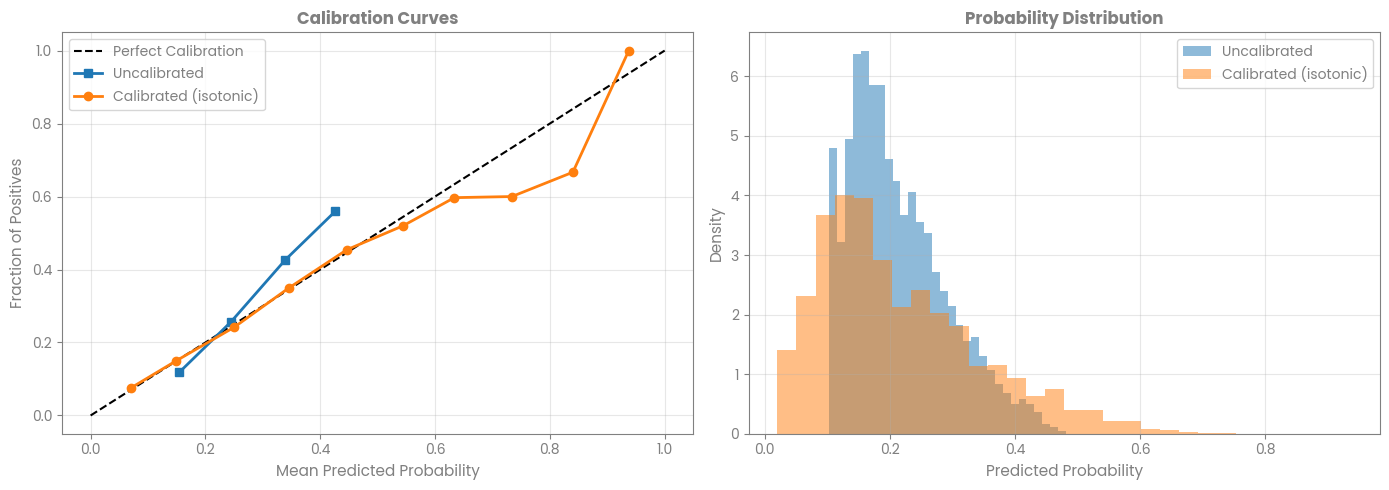

In [ ]:
# Plot calibration curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Calibration Curves
prob_true_uncalib, prob_pred_uncalib = calibration_curve(y_val, y_val_pred_uncalib, n_bins=10, strategy='uniform')
prob_true_calib, prob_pred_calib = calibration_curve(y_val, y_val_pred_calib, n_bins=10, strategy='uniform')

ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax1.plot(prob_pred_uncalib, prob_true_uncalib, 's-', label='Uncalibrated', linewidth=2)
ax1.plot(prob_pred_calib, prob_true_calib, 'o-', label=f'Calibrated ({best_method})', linewidth=2)

ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Probability Distribution
ax2.hist(y_val_pred_uncalib, bins=30, alpha=0.5, label='Uncalibrated', density=True)
ax2.hist(y_val_pred_calib, bins=30, alpha=0.5, label=f'Calibrated ({best_method})', density=True)
ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Probability Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Results**: Both calibration methods improve over uncalibrated model. **Isotonic calibration** selected as best approach, achieving:
- Brier score: 0.1524 (1.6% improvement vs uncalibrated 0.1549)
- Log loss: 0.4728 (1.6% improvement vs uncalibrated 0.4807)
- ROC-AUC: 0.7077 (maintained discrimination ability)

Cross-validation shows low variance (±0.0005 Brier), confirming stable calibration. Validation set confirms 1.55% Brier improvement. Calibration curves demonstrate strong alignment between predicted and observed default rates across probability bins.

### **3.5. Final Evaluation**

The calibrated model is evaluated on the held-out test set to assess real-world performance:

- **Discrimination metrics**: ROC-AUC measures ability to rank bad loans higher than good loans
- **Calibration metrics**: Brier score and log loss assess probability quality
- **Classification metrics**: Precision, recall, F1 for default threshold performance
- **Visual diagnostics**: ROC curve, PR curve, and calibration plot validate model behavior

Test set provides unbiased estimate of model performance on unseen data, simulating production deployment.

In [ ]:
# Preprocessing
X_test_prep = preprocessor.transform(X_test)
X_test_sel = X_test_prep[:, selected_indices]

# Predictions
model = final_calibrated_model
y_pred = model.predict(X_test_sel)
y_pred_proba = model.predict_proba(X_test_sel)[:, 1]

# Metrics
print("Classification Metrics:")
metrics = {
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1-Score': f1_score(y_test, y_pred, pos_label=1),
    'Brier Score': brier_score_loss(y_test, y_pred_proba),
    'Log Loss': log_loss(y_test, y_pred_proba)
}

for metric, value in metrics.items():
    print(f"  {metric:15s}: {value:.6f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"  TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
print(f"  FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Metrics:
  ROC-AUC        : 0.708450
  Accuracy       : 0.789794
  Precision      : 0.565302
  Recall         : 0.085344
  F1-Score       : 0.148300
  Brier Score    : 0.152230
  Log Loss       : 0.472061

Confusion Matrix:
  TN: 36676 | FP:   669
  FN:  9324 | TP:   870

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0     0.7973    0.9821    0.8801     37345
         1.0     0.5653    0.0853    0.1483     10194

    accuracy                         0.7898     47539
   macro avg     0.6813    0.5337    0.5142     47539
weighted avg     0.7476    0.7898    0.7232     47539



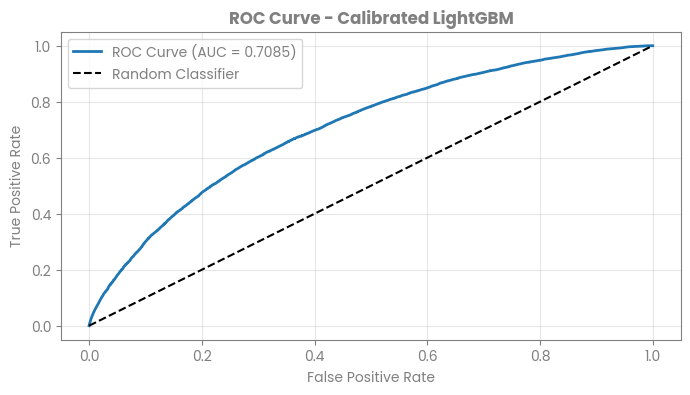

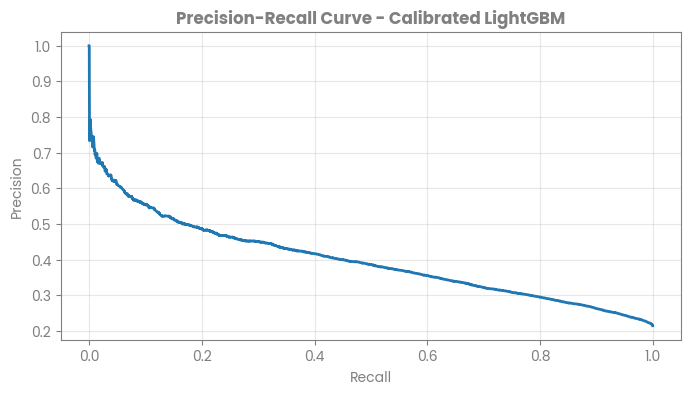

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {metrics["ROC-AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Calibrated LightGBM')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 4))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Calibrated LightGBM')
plt.grid(alpha=0.3)
plt.show()

**Results**:
- **ROC-AUC: 0.7085** - Strong discrimination maintained on unseen data, consistent with validation (0.7069)
- **Brier Score: 0.1522** - Excellent calibration quality, matching validation performance
- **Default threshold (0.5)**: High accuracy (78.98%) but low recall (8.53%) for defaults, indicating conservative predictions suitable for risk-averse lending

Confusion matrix reveals model prioritizes minimizing false positives (669) over false negatives (9,324), resulting in high precision (56.53%) but low recall for default class. This behavior aligns with business preference to avoid approving bad loans, though it misses 91.5% of actual defaults at default threshold. The strong ROC-AUC indicates excellent ranking ability—custom thresholds can be applied for different risk appetites.

## **4. Model Interpretation**

### **4.1. Feature Importance**

Extracts and visualizes feature importance scores from the Random Forest model using the built-in `feature_importances_` attribute. This reveals which features contribute most to the model's decision-making based on Gini impurity reduction across all trees.

Feature Importance:
                      feature  importance
              num__annual_inc         878
           ordinal__dti_range         678
          num__loan_to_income         670
                num__int_rate         580
           ordinal__sub_grade         487
      onehot__term_ 60 months         379
   other_cat__issue_year_2014         357
   other_cat__issue_year_2012         274
  onehot__home_ownership_RENT         229
label__purpose_small_business         184
               ordinal__grade         178
   other_cat__issue_year_2013         114
   other_cat__issue_year_2010          98
         label__addr_state_NY          55
         label__addr_state_CA          53
   label__purpose_credit_card          45
         label__addr_state_CO          21
   other_cat__issue_year_2008          20


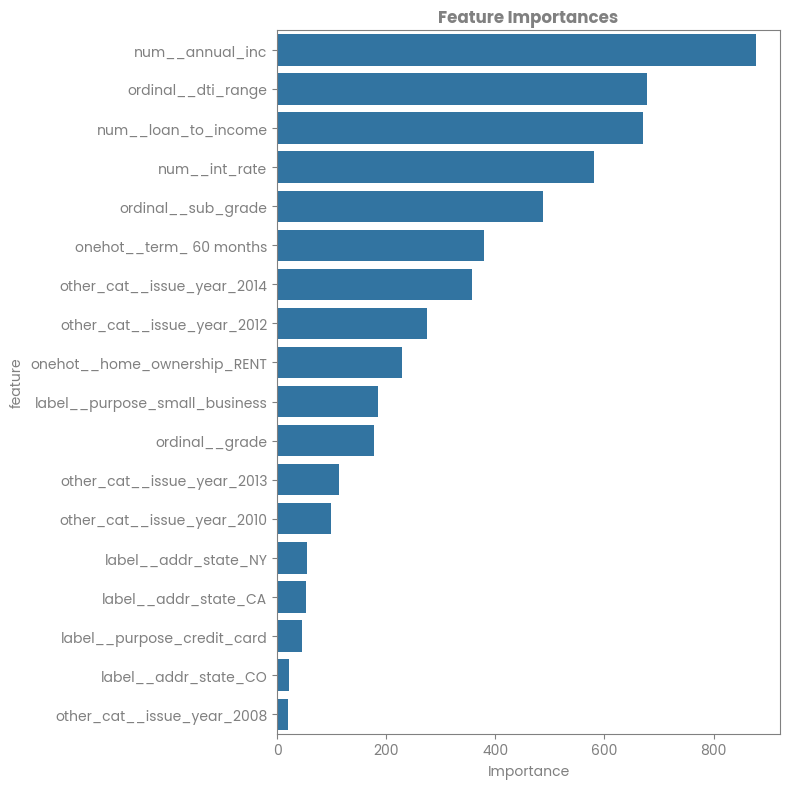

In [ ]:
# Extract feature importances
importances = uncalib_model.feature_importances_
feat_imp = (pd.DataFrame({'feature': matched_features, 'importance': importances}).sort_values('importance', ascending=False))

print("Feature Importance:")
print(feat_imp.to_string(index=False))

plt.figure(figsize=(8, 8))
sns.barplot(data=feat_imp, y='feature', x='importance')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

**Result:** `annual_inc` (878), `dti_range` (678), and `loan_to_income` (670) dominate the model's splitting decisions, indicating that borrower income, debt-to-income ratio, and loan affordability are the primary drivers of the Random Forest's prediction structure.


### **4.2. SHAP Analysis**

Computes SHAP (SHapley Additive exPlanations) values on a 1,000-sample subset of test data to measure each feature's actual contribution to individual predictions. SHAP provides more robust importance estimates than tree-based methods by accounting for feature interactions and showing directional impact.

In [ ]:
# Load model objects
base_model = final_calibrated_model.calibrated_classifiers_[0].estimator

# Prepare data
sample_size = 1000
sample_idx = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
X_sample = X_test.iloc[sample_idx]

X_prep = preprocessor.transform(X_sample)
X_selected = X_prep[:, selected_indices]

Feature Importance:
                      feature  importance
           ordinal__sub_grade    0.167907
               ordinal__grade    0.098236
          num__loan_to_income    0.093899
              num__annual_inc    0.063337
                num__int_rate    0.061797
           ordinal__dti_range    0.060735
      onehot__term_ 60 months    0.043835
   other_cat__issue_year_2014    0.028574
   other_cat__issue_year_2012    0.016233
  onehot__home_ownership_RENT    0.011208
   other_cat__issue_year_2013    0.008173
label__purpose_small_business    0.004344
   other_cat__issue_year_2010    0.002808
         label__addr_state_CA    0.001794
         label__addr_state_NY    0.001186
   label__purpose_credit_card    0.000797
   other_cat__issue_year_2008    0.000250
         label__addr_state_CO    0.000182


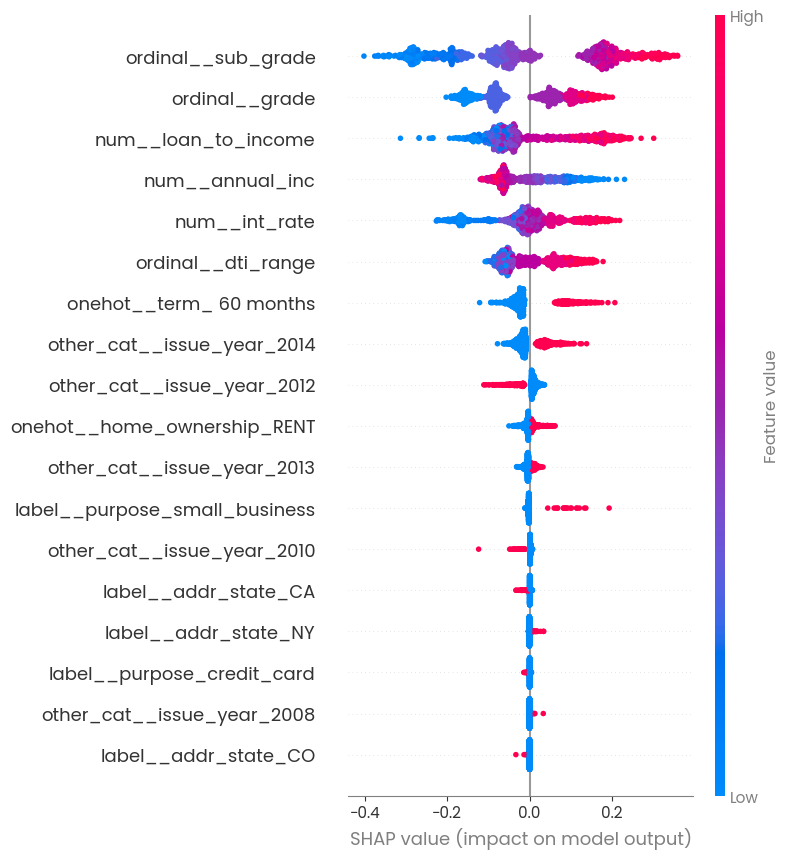

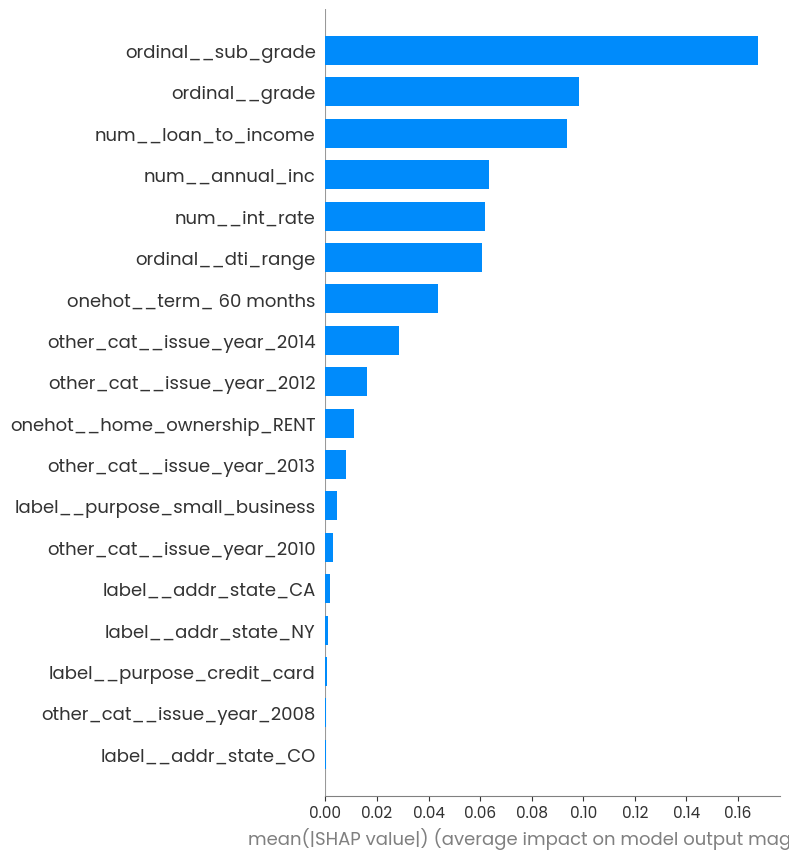

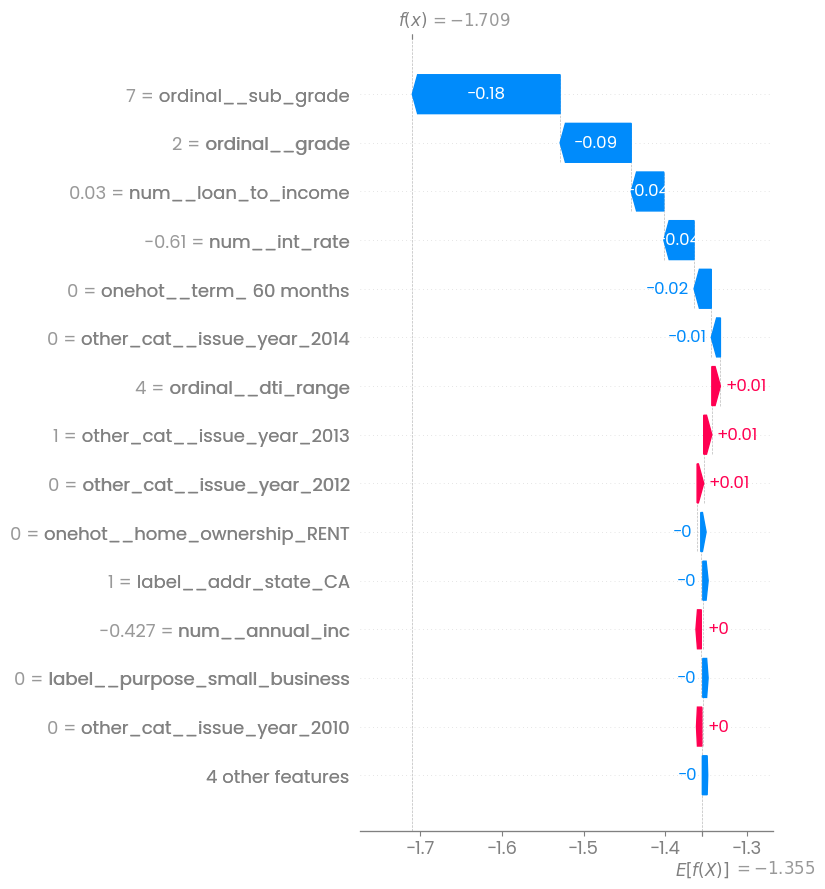

In [ ]:
# SHAP explainer
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_selected)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Feature importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': matched_features,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(importance_df.to_string(index=False))
importance_df.to_csv('shap_feature_importance.csv', index=False)

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_selected, feature_names=matched_features, max_display=20, show=False)
plt.tight_layout()
plt.show()

# Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_selected, feature_names=matched_features, plot_type='bar', max_display=20, show=False)
plt.tight_layout()
plt.show()

# Waterfall plot
shap_exp = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_selected[0], feature_names=matched_features)
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_exp, max_display=15, show=False)
plt.tight_layout()
plt.show()

**Result:** SHAP analysis reveals a different importance hierarchy than Random Forest metrics. `sub_grade` (0.168) and `grade` (0.098) emerge as the most impactful features—nearly double the influence of other variables—suggesting that Lending Club's risk rating system captures default risk more effectively than raw financial metrics. `loan_to_income` (0.094) ranks third, while `annual_inc` drops to fourth place (0.063), indicating that borrower affordability relative to loan size matters more than absolute income level. The summary plot shows clear directional patterns: higher sub_grades (worse ratings) and longer loan terms consistently push predictions toward default, while the waterfall plot demonstrates how features cumulatively shift individual predictions from the baseline probability.

## **5. Risk Tier Segmentation**

Segments test set predictions into five risk tiers using custom probability thresholds calibrated to distinct default rate ranges. The model assigns each loan a default probability, which is then categorized into tiers: Very Low (0-11%), Low (11-23%), Medium (23-43%), High (43-62%), and Very High (62-100%).

In [ ]:
# Run the final calibrated model on the prepared test set
model = final_calibrated_model
preprocessor = preprocessor
selected_indices = selected_indices

X_test_prep = preprocessor.transform(X_test)
X_test_sel = X_test_prep[:, selected_indices]

y_pred_proba = model.predict_proba(X_test_sel)[:, 1]

In [ ]:
# Summarize risk tiers using custom probability thresholds
custom_thresholds = [0, 0.11, 0.23, 0.43, 0.62, 1.0]
tier_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

tiers_custom = pd.cut(y_pred_proba, bins=custom_thresholds, labels=tier_labels, include_lowest=True)

tier_summary = pd.DataFrame({
    'Tier': tier_labels,
    'Threshold_Min': custom_thresholds[:-1],
    'Threshold_Max': custom_thresholds[1:],
    'Count': [sum(tiers_custom == label) for label in tier_labels],
    'Actual_Default_Rate': [y_test[tiers_custom == label].mean() if sum(tiers_custom == label) > 0 else 0 for label in tier_labels],
    'Avg_Predicted_Prob': [y_pred_proba[tiers_custom == label].mean() if sum(tiers_custom == label) > 0 else 0 for label in tier_labels]
})

tier_summary['Percentage'] = (tier_summary['Count'] / len(y_test) * 100).round(2)

print("Tier Summary:")
print(tier_summary.to_string(index=False))

Tier Summary:
     Tier  Threshold_Min  Threshold_Max  Count  Actual_Default_Rate  Avg_Predicted_Prob  Percentage
 Very Low           0.00           0.11  10644             0.075254            0.074942       22.39
      Low           0.11           0.23  18514             0.163174            0.162560       38.94
   Medium           0.23           0.43  14751             0.309403            0.309560       31.03
     High           0.43           0.62   3423             0.486415            0.496512        7.20
Very High           0.62           1.00    207             0.690821            0.665673        0.44


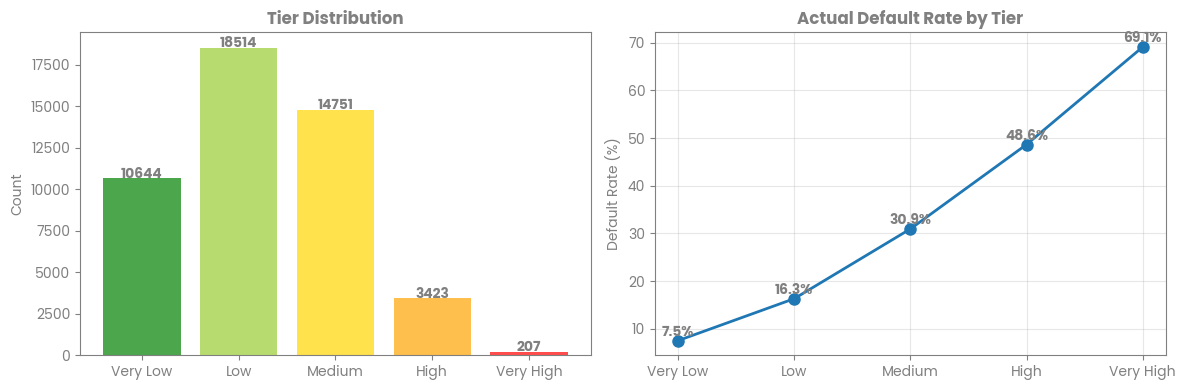

In [ ]:
# Plot tier distribution and actual default rates
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

tier_counts_q = tier_summary['Count'].values
axes[0].bar(tier_labels, tier_counts_q, color=['green', 'yellowgreen', 'gold', 'orange', 'red'], alpha=0.7)
axes[0].set_title('Tier Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(tier_counts_q):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold', color='#808080')

default_rates_q = tier_summary['Actual_Default_Rate'].values * 100
axes[1].plot(tier_labels, default_rates_q, marker='o', linewidth=2, markersize=8)
axes[1].set_title('Actual Default Rate by Tier', fontweight='bold')
axes[1].set_ylabel('Default Rate (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(alpha=0.3)
for i, v in enumerate(default_rates_q):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', color='#808080')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate high-risk tiers and compare expected vs actual defaults
results_df = pd.DataFrame({
    'predicted_probability': y_pred_proba,
    'actual_default': y_test.values,
    'tier_custom': tiers_custom.to_numpy()
})

high_risk_custom = results_df[results_df['tier_custom'].isin(['High', 'Very High'])]

print(f"High + Very High Risk: {len(high_risk_custom):,} loans ({len(high_risk_custom)/len(results_df)*100:.1f}%)")
print(f"Expected defaults in High Risk: {high_risk_custom['predicted_probability'].sum():.0f} loans")
print(f"Actual defaults in High Risk: {high_risk_custom['actual_default'].sum():.0f} loans")

High + Very High Risk: 3,630 loans (7.6%)
Expected defaults in High Risk: 1837 loans
Actual defaults in High Risk: 1808 loans


**Result:** The model demonstrates strong calibration with actual default rates closely tracking predicted probabilities across all tiers. Very Low risk borrowers (22.4% of portfolio) default at only 7.5%, while Medium risk (31.0% of portfolio) shows a sharp jump to 30.9% default rate, a critical inflection point. High and Very High risk tiers, comprising just 7.6% of loans, concentrate nearly half of all defaults with rates of 48.6% and 69.1% respectively. The model's precision is validated by the High+Very High tier: predicted 1,837 defaults versus 1,808 actual (98.4% accuracy), demonstrating excellent probability calibration. This segmentation enables targeted risk-based pricing and automated approval thresholds, with the Medium tier representing the key decision boundary where default risk becomes material.

## **6. Model Packaging & Validation**

Saves all model components, metadata, and prediction artifacts into production-ready packages with comprehensive documentation for deployment, monitoring, and audit compliance.

In [ ]:
# Save results
calibration_package = {
    'calibrated_model': final_calibrated_model,
    'uncalibrated_model': uncalib_model,
    'preprocessor': preprocessor,
    'selected_features': matched_features,
    'selected_indices': selected_indices,
    'original_features': selected_features,
    'best_method': best_method,
    'cv_results': calibration_results,
    'val_results': val_results,
    'best_params': best_params
}

joblib.dump(calibration_package, 'calibrated_model_package.pkl')
results_df.to_csv('calibration_cv_results.csv')

In [ ]:
# Save model metadata for documentation and reproducibility
model_metadata = {
    'model_name': 'Credit Risk Scoring Model',
    'model_version': '1.0',
    'train_date': datetime.datetime.now().strftime('%Y-%m-%d'),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'features_used': matched_features,
    'model_type': type(final_calibrated_model).__name__,
    'threshold_strategy': 'custom_business_logic',
    'thresholds': custom_thresholds,
    'tier_labels': tier_labels
}

joblib.dump(model_metadata, 'model_metadata.pkl')

['model_metadata.pkl']

In [ ]:
# Store key performance metrics and save for audit use
performance_metrics = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'brier_score': brier_score_loss(y_test, y_pred_proba),
    'log_loss': log_loss(y_test, y_pred_proba),
    'overall_default_rate': y_test.mean(),
    'predicted_default_rate': y_pred_proba.mean(),
    'calibration_error': abs(y_test.mean() - y_pred_proba.mean()),
    'n_high_risk': len(high_risk_custom),
    'high_risk_percentage': len(high_risk_custom)/len(y_test)*100,
    'tier_summary': tier_summary.to_dict()
}
joblib.dump(performance_metrics, 'model_performance_metrics.pkl')

['model_performance_metrics.pkl']

In [ ]:
# Finalize prediction function and assemble production package
def predict_risk_tier(new_data, model_package):
    model = model_package['calibrated_model']
    preprocessor = model_package['preprocessor']
    selected_indices = model_package['selected_indices']

    X_prep = preprocessor.transform(new_data)
    X_sel = X_prep[:, selected_indices]

    proba = model.predict_proba(X_sel)[:, 1]

    thresholds = model_package['thresholds']
    tier_labels = model_package['tier_labels']

    tiers = pd.cut(
        proba,
        bins=thresholds,
        labels=tier_labels,
        include_lowest=True
    )

    return pd.DataFrame({
        'predicted_probability': proba,
        'risk_tier': tiers
    })


# Build the production package
production_package = {
    'predict_function': predict_risk_tier,
    'calibrated_model': final_calibrated_model,
    'preprocessor': preprocessor,
    'selected_indices': selected_indices,
    'thresholds': custom_thresholds,
    'tier_labels': tier_labels,
    'metadata': model_metadata
}

joblib.dump(production_package, 'production_model_package.pkl')

['production_model_package.pkl']

In [ ]:
# Save final tiering results for later analysis
tier_results = {
    'tier_summary': tier_summary,
    'tier_labels': tier_labels,
    'custom_thresholds': custom_thresholds,
    'y_pred_proba': y_pred_proba,
    'tiers_custom': tiers_custom
}
joblib.dump(tier_results, 'risk_tier_results.pkl')

['risk_tier_results.pkl']

In [ ]:
# Export a full validation report with model details, metrics, and policy guidance
validation_report = {
    'model_info': model_metadata,
    'performance_metrics': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v for k, v in performance_metrics.items() if k != 'tier_summary'},
    'tier_performance': tier_summary.to_dict('records'),
    'business_recommendations': {
        'Very Low': 'Auto-approve | Standard rates | Minimal monitoring',
        'Low': 'Auto-approve | Standard rates | Quarterly review',
        'Medium': 'Conditional approval | Moderate rates | Monthly review',
        'High': 'Manual review required | Higher rates/collateral | Weekly monitoring',
        'Very High': 'Reject or strict terms | Maximum rates+collateral | Daily monitoring'
    }
}

with open('validation_report.json', 'w') as f:
    json.dump(validation_report, f, indent=4, default=str)